<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

In [1147]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Get the Data

## Download the Data

In [1150]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [1151]:
fetch_housing_data()

/var/folders/nb/7tdjzjb96030ypwzz43_rpd40000gn/T/ipykernel_662/1387014147.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


In [1152]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

## Create a Test Set

In [1154]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [1155]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [1156]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [1157]:
len(test_set)

4128

In [1158]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

The implementation of `test_set_check()` above works fine in both Python 2 and Python 3. In earlier releases, the following implementation was proposed, which supported any hash function, but was much slower and did not support Python 2:

In [1160]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

If you want an implementation that supports any hash function and is compatible with both Python 2 and Python 3, here is one:

In [1162]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [1163]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [1164]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [1165]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [1166]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [1167]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


<Axes: >

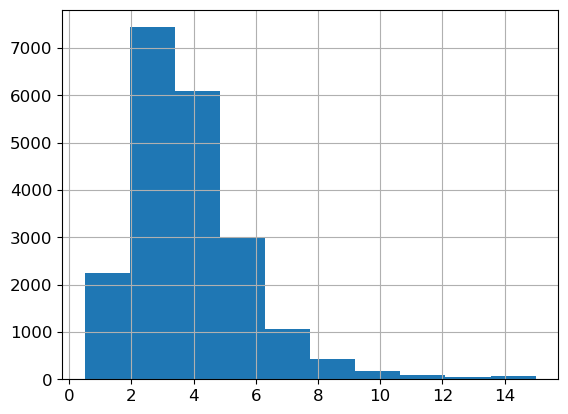

In [1168]:
housing["median_income"].hist()

In [1169]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [1170]:
housing["income_cat"].value_counts()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

<Axes: >

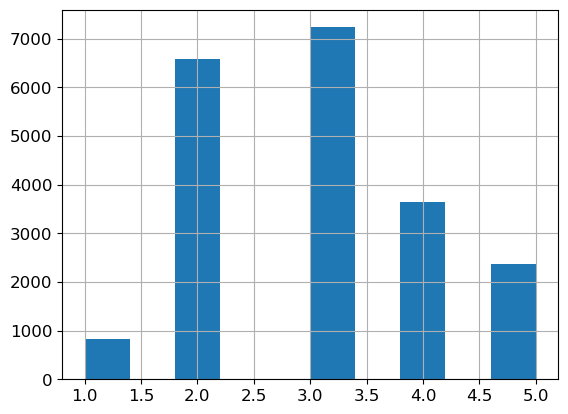

In [1171]:
housing["income_cat"].hist()

In [1172]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [1173]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [1174]:
housing["income_cat"].value_counts() / len(housing)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

In [1175]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [1176]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
income_cat,,,,,
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


In [1177]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Prepare the Data for Machine Learning Algorithms

In [1179]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

In [1181]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3

/var/folders/nb/7tdjzjb96030ypwzz43_rpd40000gn/T/ipykernel_662/1754626042.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3


In [1182]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


In [1183]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [1184]:
housing_num = housing.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [1185]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [1186]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Check that this is the same as manually computing the median of each attribute:

In [1188]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Transform the training set:

In [1190]:
X = imputer.transform(housing_num)

In [1191]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [1192]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580


In [1193]:
imputer.strategy

'median'

In [1194]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [1195]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


## Handling Text and Categorical Attributes

In [1197]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [1198]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [1199]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [1200]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [1201]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Custom Transformers

In [1203]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [1204]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices

In [1205]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241


## Transformation Pipelines

In [1207]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [1208]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

In [1209]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [1210]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [1211]:
housing_prepared.shape

(16512, 16)

# Select and Train a Model

## Training and Evaluating on the Training Set

In [1214]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [1215]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68633.40810776998

In [1216]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49448.131359011626

In [1217]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [1218]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## Better Evaluation Using Cross-Validation

In [1220]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [1221]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


In [1222]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71800.38078269 64114.99166359 67844.95431254 68635.19072082
 66801.98038821 72531.04505346 73992.85834976 68824.54092094
 66474.60750419 70143.79750458]
Mean: 69116.4347200802
Standard deviation: 2880.6588594759014


In [1223]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [1224]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18650.698705770003

In [1225]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


In [1226]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69116.434720
std       3036.481053
min      64114.991664
25%      67062.723869
50%      68729.865821
75%      71386.234963
max      73992.858350
dtype: float64

In [1227]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111095.06635291968

# Fine-Tune Your Model

## Grid Search

In [1399]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [1400]:
negative_mse = grid_search.best_score_
rmse_grid_forest = np.sqrt(-negative_mse)
rmse_grid_forest

49898.98913455217

In [1401]:
grid_forest_params = grid_search.best_params_

In [1402]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [1403]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63895.161577951665 {'max_features': 2, 'n_estimators': 3}
54916.32386349543 {'max_features': 2, 'n_estimators': 10}
52891.66240619666 {'max_features': 2, 'n_estimators': 30}
60075.3680329983 {'max_features': 4, 'n_estimators': 3}
52495.01284985185 {'max_features': 4, 'n_estimators': 10}
50187.24324926565 {'max_features': 4, 'n_estimators': 30}
58064.73529982314 {'max_features': 6, 'n_estimators': 3}
51519.32062366315 {'max_features': 6, 'n_estimators': 10}
49969.80441627874 {'max_features': 6, 'n_estimators': 30}
58895.824998155826 {'max_features': 8, 'n_estimators': 3}
52459.79624724529 {'max_features': 8, 'n_estimators': 10}
49898.98913455217 {'max_features': 8, 'n_estimators': 30}
62381.765106921855 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54476.57050944266 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59974.60028085155 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52754.5632813202 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

In [1404]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.038557,0.004181,0.002072,0.000457,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.119912e+09,-3.723465e+09,...,-4.082592e+09,1.867375e+08,18,-1.155630e+09,-1.089726e+09,-1.153843e+09,-1.118149e+09,-1.093446e+09,-1.122159e+09,2.834288e+07
1,0.117236,0.001041,0.006232,0.000666,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.973521e+09,-2.810319e+09,...,-3.015803e+09,1.139808e+08,11,-5.982947e+08,-5.904781e+08,-6.123850e+08,-5.727681e+08,-5.905210e+08,-5.928894e+08,1.284978e+07
2,0.355476,0.002759,0.016492,0.000416,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.801229e+09,-2.671930e+09,...,-2.797528e+09,8.014389e+07,9,-4.412567e+08,-4.324781e+08,-4.553722e+08,-4.320746e+08,-4.315783e+08,-4.385520e+08,9.140206e+06
3,0.062452,0.001507,0.001994,0.000349,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.528743e+09,-3.490303e+09,...,-3.609050e+09,1.375683e+08,16,-9.782368e+08,-9.806455e+08,-1.003780e+09,-1.016515e+09,-1.011270e+09,-9.980896e+08,1.577372e+07
4,0.199471,0.001349,0.005474,0.000332,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.742620e+09,-2.609311e+09,...,-2.755726e+09,1.182604e+08,7,-5.063215e+08,-5.257983e+08,-5.081984e+08,-5.174405e+08,-5.282066e+08,-5.171931e+08,8.882622e+06
5,0.591771,0.001560,0.015940,0.000401,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.522176e+09,-2.440241e+09,...,-2.518759e+09,8.488084e+07,3,-3.776568e+08,-3.902106e+08,-3.885042e+08,-3.830866e+08,-3.894779e+08,-3.857872e+08,4.774229e+06
6,0.080772,0.000977,0.001624,0.000188,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.362127e+09,-3.311863e+09,...,-3.371513e+09,1.378086e+08,13,-8.909397e+08,-9.583733e+08,-9.000201e+08,-8.964731e+08,-9.151927e+08,-9.121998e+08,2.444837e+07
7,0.277920,0.007241,0.005578,0.000347,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.622099e+09,-2.669655e+09,...,-2.654240e+09,6.967978e+07,5,-4.939906e+08,-5.145996e+08,-5.023512e+08,-4.959467e+08,-5.147087e+08,-5.043194e+08,8.880106e+06
8,0.838934,0.007211,0.015647,0.000328,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.446142e+09,-2.446594e+09,...,-2.496981e+09,7.357046e+07,2,-3.760968e+08,-3.876636e+08,-3.875307e+08,-3.760938e+08,-3.861056e+08,-3.826981e+08,5.418747e+06
9,0.108189,0.001620,0.001523,0.000066,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.590333e+09,-3.232664e+09,...,-3.468718e+09,1.293758e+08,14,-9.505012e+08,-9.166119e+08,-9.033910e+08,-9.070642e+08,-9.459386e+08,-9.247014e+08,1.973471e+07


In [1405]:
from sklearn.model_selection import GridSearchCV

param_grid_lin_reg = {
    'fit_intercept': [True, False], 
    'n_jobs': [None, -1]  
}

lin_reg = LinearRegression()
grid_search_lin_reg = GridSearchCV(lin_reg, param_grid=param_grid_lin_reg, 
                                   cv=5, scoring='neg_mean_squared_error'
                                   )
grid_search_lin_reg.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False], 'n_jobs': [None, -1]},
             scoring='neg_mean_squared_error')

In [1406]:
negative_mse = grid_search_lin_reg.best_score_
rmse_grid_lin = np.sqrt(-negative_mse)
rmse_grid_lin

69166.43089909128

In [1407]:
grid_lin_params = grid_search_lin_reg.best_params_
grid_lin_params

{'fit_intercept': False, 'n_jobs': None}

In [1408]:
from sklearn.model_selection import GridSearchCV

param_grid_tree = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

tree_reg = DecisionTreeRegressor(random_state=42)
grid_search_tree = GridSearchCV(tree_reg, param_grid=param_grid_tree, 
                                cv=5, scoring='neg_mean_squared_error')
grid_search_tree.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             scoring='neg_mean_squared_error')

In [1409]:
negative_mse = grid_search_tree.best_score_
rmse_grid_tree = np.sqrt(-negative_mse)
rmse_grid_tree

60069.74163012489

In [1410]:
grid_tree_params = grid_search_tree.best_params_
grid_tree_params

{'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 10,
 'min_samples_split': 2}

## Randomized Search

In [1412]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x15eb886b0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x15c7ce630>},
                   random_state=42, scoring='neg_mean_squared_error')

In [1413]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49117.55344336652 {'max_features': 7, 'n_estimators': 180}
51450.63202856348 {'max_features': 5, 'n_estimators': 15}
50700.386174457635 {'max_features': 3, 'n_estimators': 72}
50783.614493515 {'max_features': 5, 'n_estimators': 21}
49162.89877456354 {'max_features': 7, 'n_estimators': 122}
50663.56285209076 {'max_features': 3, 'n_estimators': 75}
50523.94360622104 {'max_features': 3, 'n_estimators': 88}
49521.76339475961 {'max_features': 5, 'n_estimators': 100}
50306.36122428185 {'max_features': 3, 'n_estimators': 150}
65167.02018649492 {'max_features': 5, 'n_estimators': 2}


In [1414]:
negative_mse = rnd_search.best_score_
rmse_rnd_forest = np.sqrt(-negative_mse)
rmse_rnd_forest

49117.55344336652

In [1415]:
best_forest_params = rnd_search.best_params_

In [1416]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'max_depth': randint(1, 20),  
    'min_samples_split': randint(2, 20),  
    'min_samples_leaf': randint(1, 20), 
    'max_features': ['sqrt', 'log2', None]  
}

tree_reg = DecisionTreeRegressor(random_state=42)
rnd_tree_search = RandomizedSearchCV(tree_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_tree_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x15f2ef7a0>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x15f462870>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x15f4604d0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [1417]:
cvres = rnd_tree_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

68463.03382170892 {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 12}
67358.68111351473 {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 12}
66182.39370100564 {'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 9}
88370.99321119268 {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 13}
71700.9604077972 {'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 13}
64724.489982447674 {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 17, 'min_samples_split': 11}
59226.53930456097 {'max_depth': 16, 'max_features': None, 'min_samples_leaf': 15, 'min_samples_split': 13}
88370.99321119268 {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 19, 'min_samples_split': 8}
60155.11319296968 {'max_depth': 9, 'max_features': None, 'min_samples_leaf': 18, 'min_samples_split': 5}
64074.16023248681 {'max_depth': 14, 

In [1418]:
negative_mse = rnd_tree_search.best_score_
rmse_rnd_tree = np.sqrt(-negative_mse)
rmse_rnd_tree

59226.53930456097

In [1419]:
best_tree_params = rnd_tree_search.best_params_
best_tree_params

{'max_depth': 16,
 'max_features': None,
 'min_samples_leaf': 15,
 'min_samples_split': 13}

In [1420]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'fit_intercept': [True, False],
    'n_jobs': [None, -1]  
}

lin_reg = LinearRegression()
rnd_lin_search = RandomizedSearchCV(lin_reg, param_distributions=param_distribs,
                                n_iter=4, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_lin_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=LinearRegression(), n_iter=4,
                   param_distributions={'fit_intercept': [True, False],
                                        'n_jobs': [None, -1]},
                   random_state=42, scoring='neg_mean_squared_error')

In [1421]:
negative_mse = rnd_lin_search.best_score_
rmse_rnd_lin = np.sqrt(-negative_mse)
rmse_rnd_lin

69166.43089909128

In [1422]:
best_lin_params = rnd_lin_search.best_params_
best_lin_params

{'n_jobs': None, 'fit_intercept': False}

## Analyze the Best Models and Their Errors

In [1458]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([7.13721236e-02, 6.28935545e-02, 4.30092772e-02, 1.64086555e-02,
       1.55670107e-02, 1.64745016e-02, 1.53753328e-02, 3.45190341e-01,
       5.95258394e-02, 1.10738856e-01, 6.97457058e-02, 8.67185471e-03,
       1.58662678e-01, 6.67961748e-05, 2.68890007e-03, 3.60857368e-03])

In [1460]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.34519034100319007, 'median_income'),
 (0.15866267751808205, 'INLAND'),
 (0.1107388558918982, 'pop_per_hhold'),
 (0.07137212359389712, 'longitude'),
 (0.06974570580531124, 'bedrooms_per_room'),
 (0.06289355447798799, 'latitude'),
 (0.05952583935728965, 'rooms_per_hhold'),
 (0.04300927718434754, 'housing_median_age'),
 (0.016474501566255607, 'population'),
 (0.016408655481155894, 'total_rooms'),
 (0.015567010725199516, 'total_bedrooms'),
 (0.015375332753137499, 'households'),
 (0.008671854710510334, '<1H OCEAN'),
 (0.003608573683092268, 'NEAR OCEAN'),
 (0.002688900073839445, 'NEAR BAY'),
 (6.679617480568294e-05, 'ISLAND')]

## Evaluate Your System on the Test Set

In [1463]:
final_model = rnd_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [1465]:
final_rmse

46981.841079394515

In [1467]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45009.73121871, 48874.43992557])

# Extra material

## A full pipeline with both preparation and prediction

In [1263]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([ 86208., 304704., 153536., 185728., 244416.])

## Model persistence using joblib

In [1265]:
my_model = full_pipeline_with_predictor

In [1266]:
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## Example SciPy distributions for `RandomizedSearchCV`

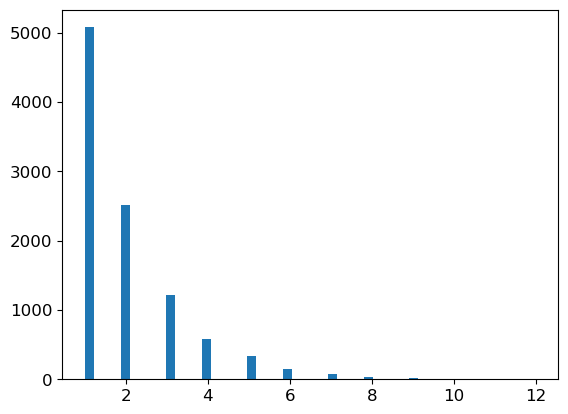

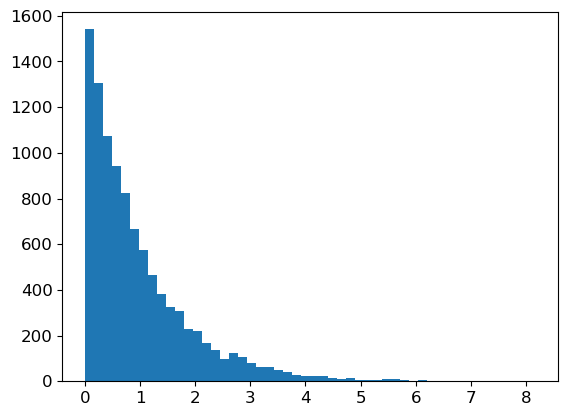

In [1268]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# Comparison between Models

## SVR Regressor

In [1271]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ..............................C=10.0, kernel=linear; total time=   2.0s
[CV] END ..............................C=10.0, kernel=linear; total time=   2.0s
[CV] END ..............................C=10.0, kernel=linear; total time=   2.0s
[CV] END ..............................C=10.0, kernel=linear; total time=   2.0s
[CV] END ..............................C=10.0, kernel=linear; total time=   2.0s
[CV] END ..............................C=30.0, kernel=linear; total time=   2.0s
[CV] END ..............................C=30.0, kernel=linear; total time=   1.9s
[CV] END ..............................C=30.0, kernel=linear; total time=   2.0s
[CV] END ..............................C=30.0, kernel=linear; total time=   1.9s
[CV] END ..............................C=30.0, kernel=linear; total time=   1.9s
[CV] END .............................C=100.0, kernel=linear; total time=   1.9s
[CV] END .............................C=100.0, 

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [1272]:
negative_mse = grid_search.best_score_
rmse_grid_svr = np.sqrt(-negative_mse)
rmse_grid_svr

70286.61835634754

In [1273]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

In [1274]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   2.0s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   2.0s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   2.0s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   2.0s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   2.0s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   3.7s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   3.7s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   3.8s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   3.8s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   3.7s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, 

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15e045f70>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15f2846b0>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [1275]:
negative_mse = rnd_search.best_score_
rmse_rnd_svr = np.sqrt(-negative_mse)
rmse_rnd_svr

54751.690093335324

In [1276]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

In [1277]:
import pandas as pd
import numpy as np

best_grid_svr_params = grid_search.best_params_

best_rnd_svr_params = rnd_search.best_params_

best_results = pd.DataFrame({
    'Search Method': ['GridSearchCV', 'RandomizedSearchCV'],
    'Best C': [best_grid_svr_params['C'], best_rnd_svr_params['C']],
    'Best Gamma': [best_grid_svr_params.get('gamma', 'N/A'), best_rnd_svr_params.get('gamma', 'N/A')],
    'Best Kernel': [best_grid_svr_params.get('kernel', 'N/A'), best_rnd_svr_params.get('kernel', 'N/A')],    
    'Best RMSE': [rmse_grid_svr, rmse_rnd_svr]
})
best_results

,Search Method,Best C,Best Gamma,Best Kernel,Best RMSE
0,GridSearchCV,30000.000000,N/A,linear,70286.618356
1,RandomizedSearchCV,157055.109894,0.26497,rbf,54751.690093


## Comparison

In [1279]:
import pandas as pd

comparison_df = pd.DataFrame({
    'Model': ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'SVR'],
    'Best RMSE': [rmse_rnd_lin, rmse_rnd_tree, rmse_rnd_forest, rmse_rnd_svr],
    'Best Parameters': [best_lin_params, best_tree_params, best_forest_params, best_rnd_svr_params]
})

pd.set_option('display.max_colwidth', None)
comparison_df

,Model,Best RMSE,Best Parameters
0,LinearRegression,69166.430899,"{'n_jobs': None, 'fit_intercept': False}"
1,DecisionTreeRegressor,59226.539305,"{'max_depth': 16, 'max_features': None, 'min_samples_leaf': 15, 'min_samples_split': 13}"
2,RandomForestRegressor,49117.553443,"{'max_features': 7, 'n_estimators': 180}"
3,SVR,54751.690093,"{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}"


In [1280]:
import pandas as pd

comparison_df = pd.DataFrame({ 'Model': ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'SVR'], 
                              'Best RMSE': [rmse_grid_lin, rmse_grid_tree, rmse_grid_forest, rmse_grid_svr], 
                              'Best Parameters': [grid_lin_params, grid_tree_params, grid_forest_params, best_grid_svr_params] })

pd.set_option('display.max_colwidth', None) 
comparison_df

,Model,Best RMSE,Best Parameters
0,LinearRegression,69166.430899,"{'fit_intercept': False, 'n_jobs': None}"
1,DecisionTreeRegressor,60069.741630,"{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}"
2,RandomForestRegressor,49898.989135,"{'max_features': 8, 'n_estimators': 30}"
3,SVR,70286.618356,"{'C': 30000.0, 'kernel': 'linear'}"
